In [1]:
import numpy as np
import meanderpy as mp
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
mpl.rcParams['figure.dpi'] = 600

In [188]:
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

def run_meander_simulation(freq_multiplier: float,
                           amplitude: float,
                           *,
                           n_perturb: int = 0,          # how many random perturbations
                           perturb_magnitude: float = 0.0,
                           nit: int = 501,
                           saved_ts: int = 1,
                           random_seed: int | None = None):
    # ─── physics / numerics ──────────────────────────────────────────────
    W = 50.0;  D = 1.0
    depths  = D * np.ones(nit)
    pad, deltas = 0, 50.0
    Cfs     = 0.0065 * np.ones(nit)
    crdist  = 5 * W
    kl      = 500.0 / (365*24*60*60.0)
    kv      = 1.0e-12
    dt      = 0.2 * 0.5 * 365*24*60*60.0
    dens    = 1000
    Sl      = 0.0
    t1 = t2 = t3 = 0
    aggr_factor = 0

    x_initial = np.linspace(0.1, 10_000, 1500)
    y_initial = (amplitude * 100.0) * np.sin(freq_multiplier * np.pi * x_initial / 10_000.0)

    if n_perturb and perturb_magnitude:
        # Only perturb the center node in y direction
        idx = len(x_initial) // 2
        y_initial[idx] += perturb_magnitude

    z_initial = np.zeros_like(x_initial)
    ch  = mp.Channel(x_initial, y_initial, z_initial, W, depths[0])
    chb = mp.ChannelBelt([ch], [], [0.0], [])
    chb.migrate(nit, saved_ts, deltas, pad, crdist,
                depths, Cfs, kl, kv, dt, dens,
                t1, t2, t3, aggr_factor)
    return chb

# --- Output config ---
out_dir = "/Users/braydennoh/Documents/chaosriver/4.28/touchcount"
os.makedirs(out_dir, exist_ok=True)

# --- Run 5 perturbed channels ---
freq, A  = 30.0, 3.0
dY       = 1e-10
n_runs   = 1

chb_ref = run_meander_simulation(freq, A)
perturbed_runs = [
    run_meander_simulation(freq, A, n_perturb=1, perturb_magnitude=dY, random_seed=i)
    for i in range(n_runs)
]

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [00:04<00:00, 124.66it/s]


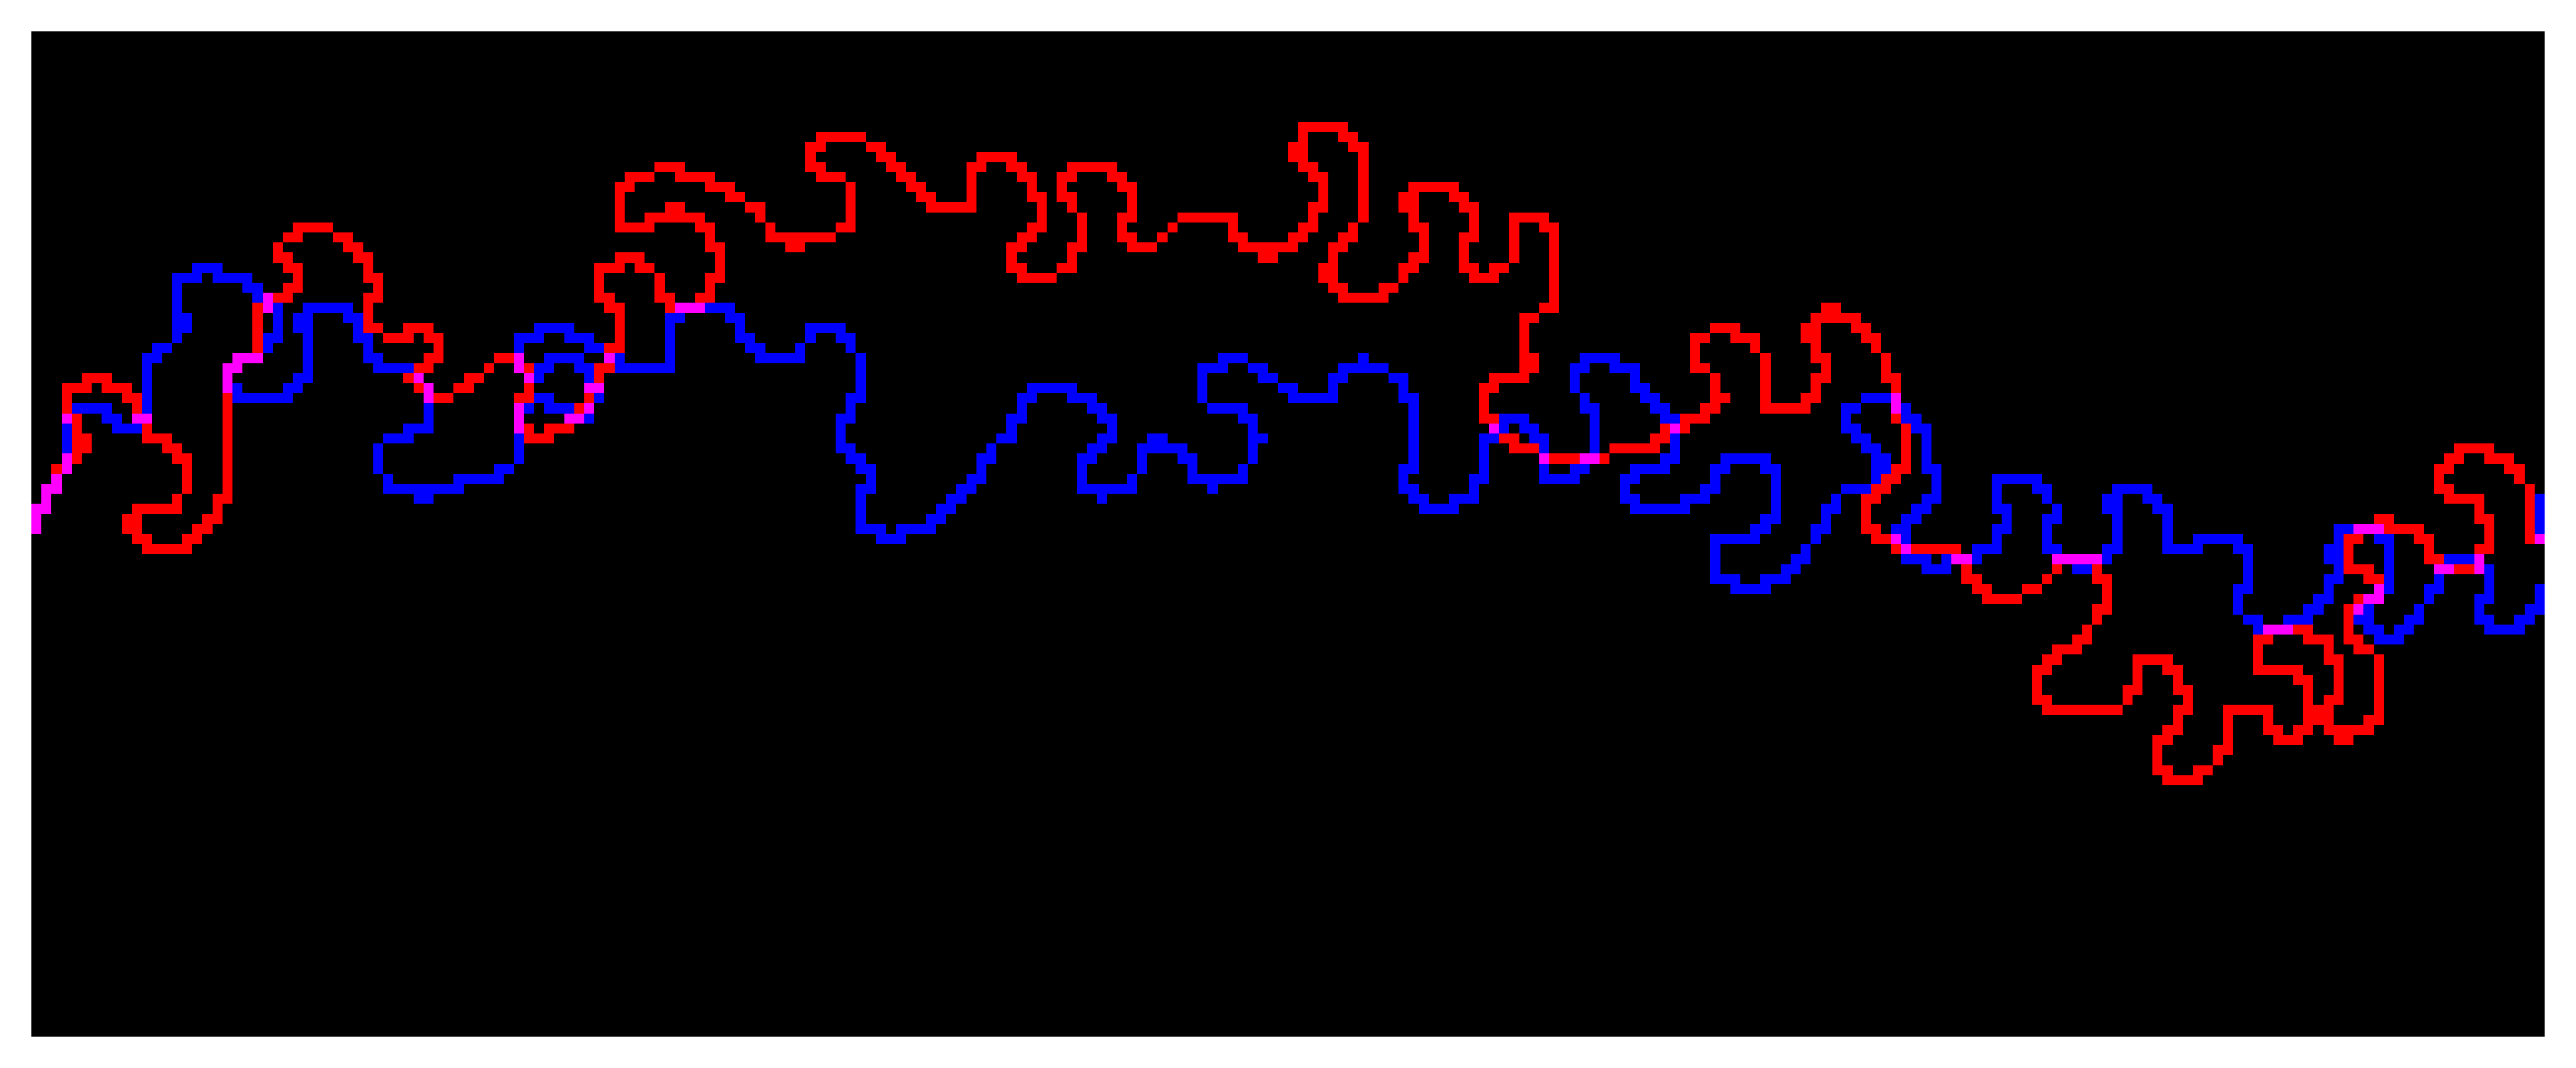

In [43]:
import numpy as np
import matplotlib.pyplot as plt

x_min, x_max = 0, 10000
y_min, y_max = -2000, 2000

# Calculate aspect ratio and set grid shape for square cells
x_range = x_max - x_min
y_range = y_max - y_min
aspect_ratio = x_range / y_range

rows = 100
cols = int(round(rows * aspect_ratio))  # Ensures square cells
grid_shape = (rows, cols)
extent = (x_min, x_max, y_min, y_max)
timestep = 300

def rasterize_to_binary_mask(x, y, grid_shape, extent, n_seg=10):
    rows, cols = grid_shape
    x_min, x_max, y_min, y_max = extent
    dx = (x_max - x_min) / cols
    dy = (y_max - y_min) / rows
    canvas = np.zeros(grid_shape, dtype=np.uint8)
    x = np.asarray(x)
    y = np.asarray(y)
    if len(x) < 2: return canvas
    all_r, all_c = [], []
    for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:]):
        xs = np.linspace(x0, x1, n_seg)
        ys = np.linspace(y0, y1, n_seg)
        c = ((xs - x_min) / dx).astype(int)
        r = ((ys - y_min) / dy).astype(int)
        all_r.append(r)
        all_c.append(c)
    c = ((x - x_min) / dx).astype(int)
    r = ((y - y_min) / dy).astype(int)
    all_r.append(r)
    all_c.append(c)
    all_r = np.concatenate(all_r)
    all_c = np.concatenate(all_c)
    mask = (0 <= all_c) & (all_c < cols) & (0 <= all_r) & (all_r < rows)
    canvas[all_r[mask], all_c[mask]] = 1
    return canvas

ref_mask = rasterize_to_binary_mask(chb_ref.channels[timestep].x,
                                    chb_ref.channels[timestep].y,
                                    grid_shape, extent)

pert_ch = perturbed_runs[0].channels[timestep]
pert_mask = rasterize_to_binary_mask(pert_ch.x, pert_ch.y, grid_shape, extent)

# Combine into RGB: R = ref, B = pert, purple = both
rgb = np.zeros((rows, cols, 3), dtype=np.uint8)
rgb[..., 0] = ref_mask * 255        # Red
rgb[..., 2] = pert_mask * 255       # Blue

# Rotate image
rgb_rot = rgb.transpose(1, 0, 2)[::-1, :]


fig, ax = plt.subplots(figsize=(8, 4))  # (width, height) in inches, so this matches a wide domain

# No need to transpose if you set the extent correctly:
ax.imshow(
    rgb,
    origin='lower',
    extent=[x_min, x_max, y_min, y_max],   # extent in domain units!
    aspect='equal'
)

ax.set_xticks([x_min, x_max])
ax.set_yticks([y_min, y_max])
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0)
plt.show()

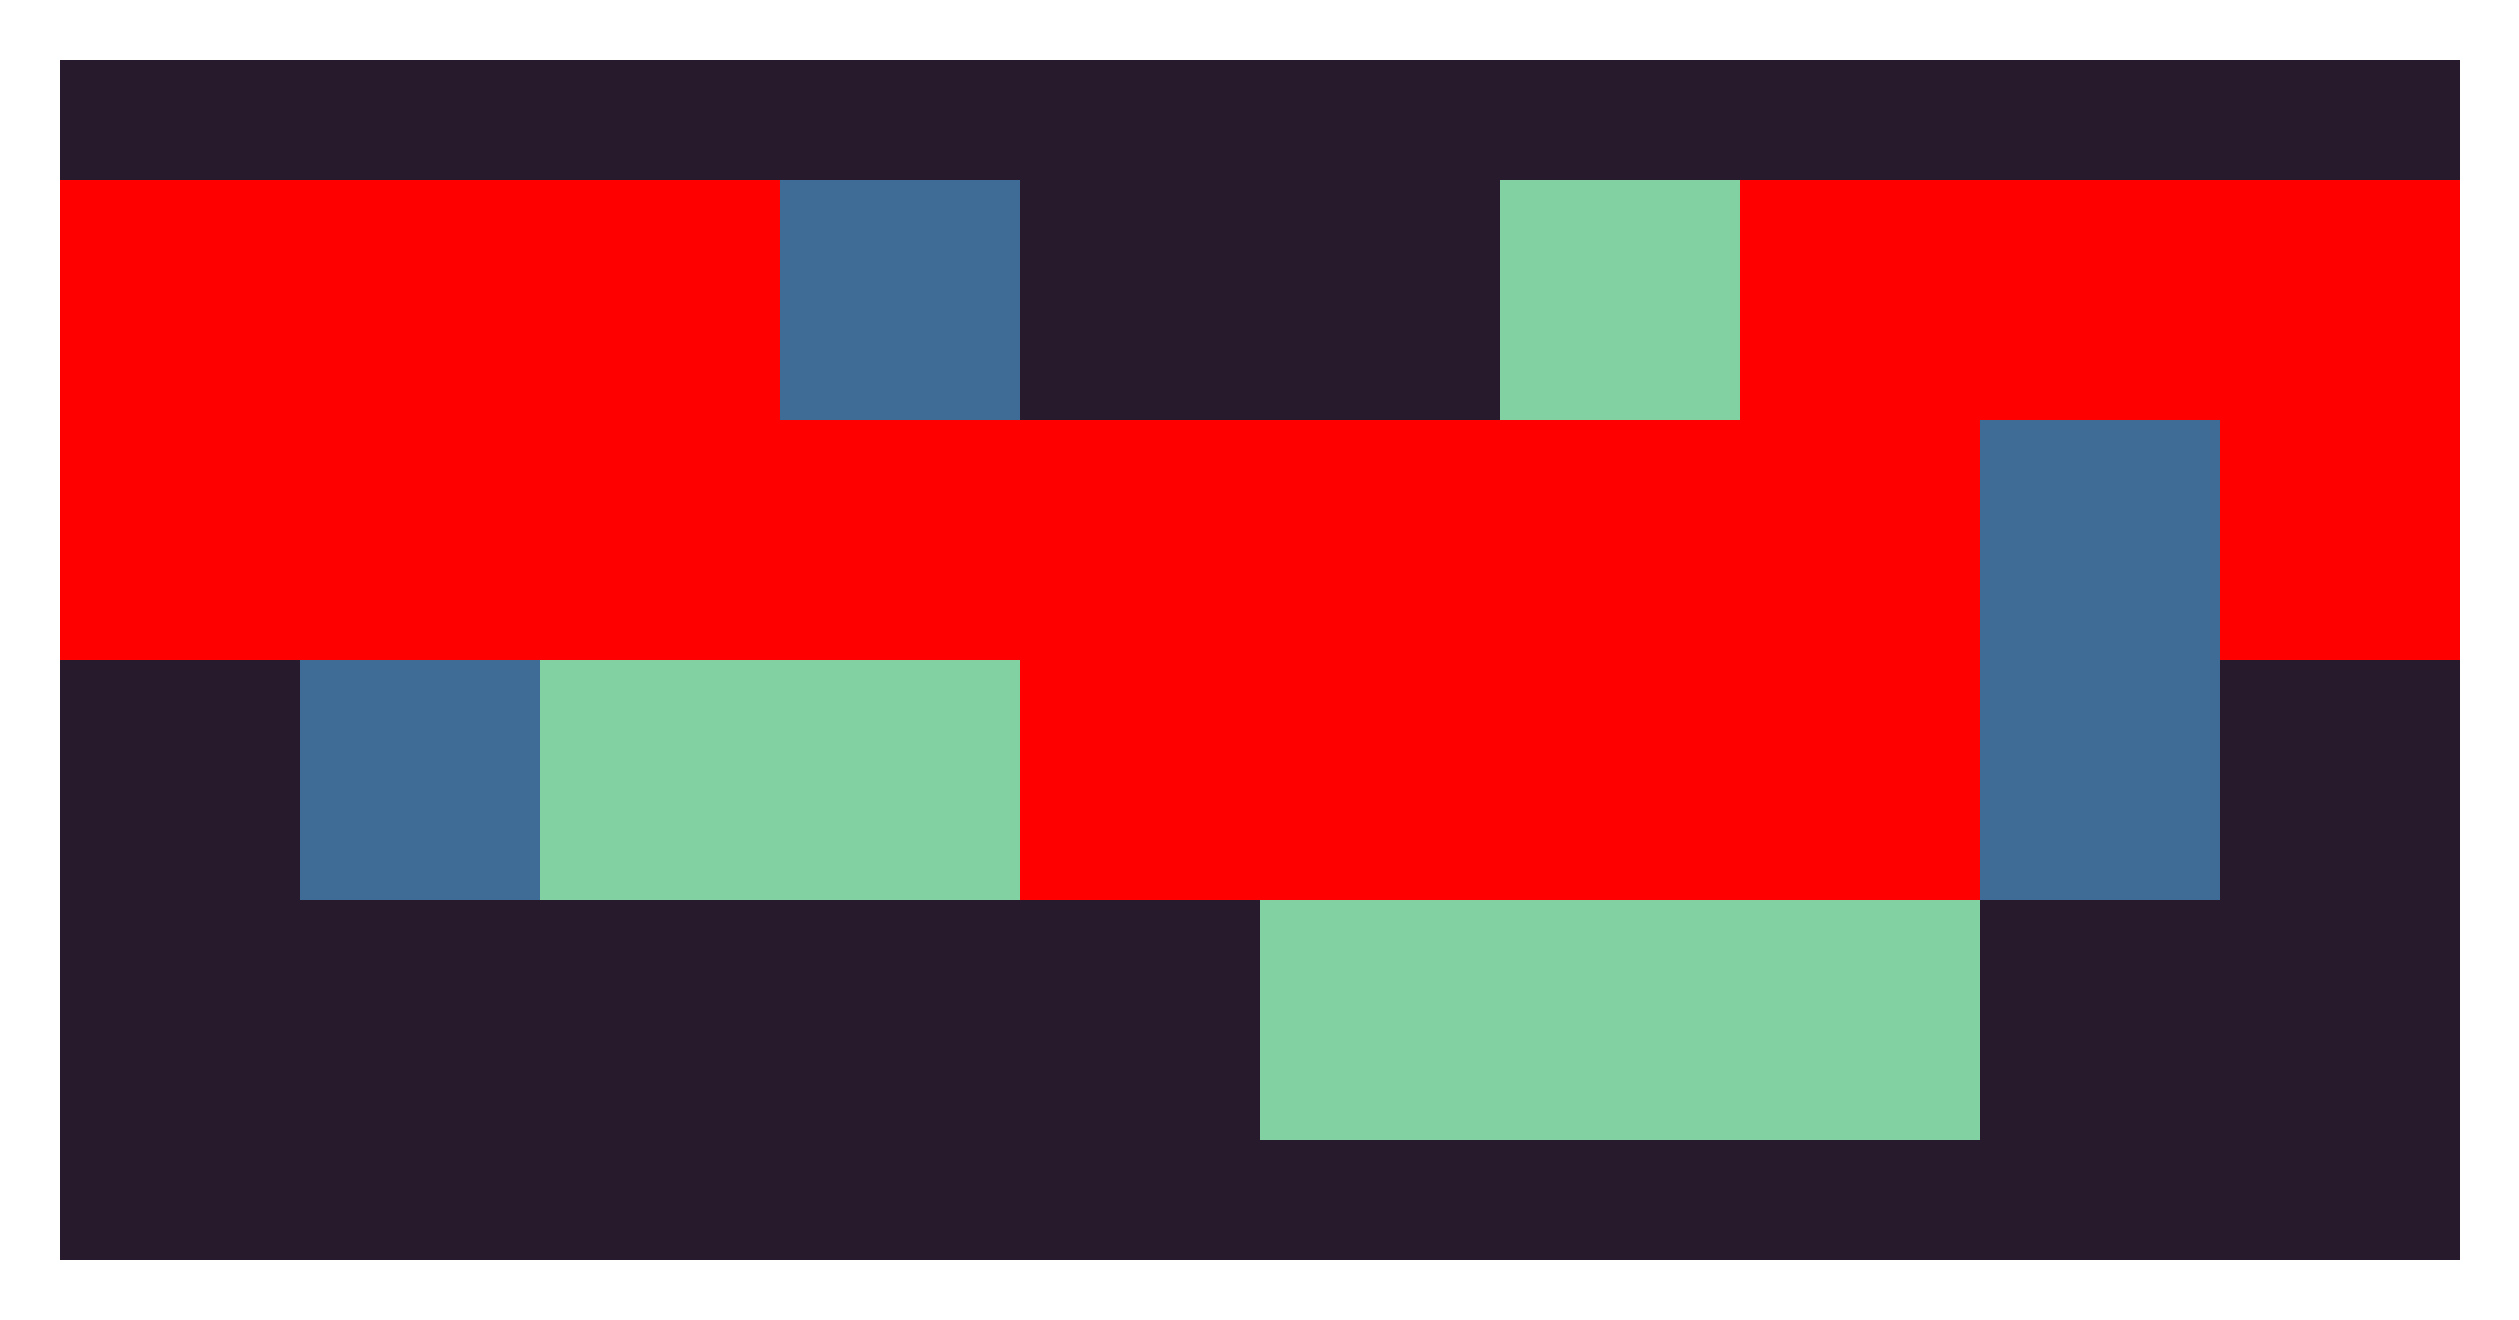

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean

x_min, x_max = 0, 10000
y_min, y_max = -2000, 2000

# Square cells
x_range = x_max - x_min
y_range = y_max - y_min
rows = 10
cols = int(round(rows * x_range / y_range))
grid_shape = (rows, cols)
extent = (x_min, x_max, y_min, y_max)
timestep = 200

def rasterize_to_binary_mask(x, y, grid_shape, extent, n_seg=100):
    rows, cols = grid_shape
    x_min, x_max, y_min, y_max = extent
    dx = (x_max - x_min) / cols
    dy = (y_max - y_min) / rows
    canvas = np.zeros(grid_shape, dtype=np.uint8)
    x = np.asarray(x)
    y = np.asarray(y)
    if len(x) < 2: return canvas
    all_r, all_c = [], []
    for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:]):
        xs = np.linspace(x0, x1, n_seg)
        ys = np.linspace(y0, y1, n_seg)
        c = ((xs - x_min) / dx).astype(int)
        r = ((ys - y_min) / dy).astype(int)
        all_r.append(r)
        all_c.append(c)
    c = ((x - x_min) / dx).astype(int)
    r = ((y - y_min) / dy).astype(int)
    all_r.append(r)
    all_c.append(c)
    all_r = np.concatenate(all_r)
    all_c = np.concatenate(all_c)
    mask = (0 <= all_c) & (all_c < cols) & (0 <= all_r) & (all_r < rows)
    canvas[all_r[mask], all_c[mask]] = 1
    return canvas

# Reference and perturbed masks (replace with your data objects)
ref_mask = rasterize_to_binary_mask(chb_ref.channels[timestep].x,
                                    chb_ref.channels[timestep].y,
                                    grid_shape, extent)
pert_ch = perturbed_runs[0].channels[timestep]
pert_mask = rasterize_to_binary_mask(pert_ch.x, pert_ch.y, grid_shape, extent)


deep = cmocean.cm.deep
color_intersect = np.array([1.0, 0.0, 0.0])            # intersection: red
color_ref      = np.array(deep(0.233333)[:3])          # reference: blue(ish)
color_pert     = np.array(deep(0.633333)[:3])          # perturbed: lighter color
color_bg       = np.array(deep(0.99999999)[:3])        # background: very dark



# Create combined mask (0: bg, 1: ref only, 2: pert only, 3: intersect)
idx = ref_mask + pert_mask * 2  # 0=bg, 1=ref, 2=pert, 3=both

rgb = np.zeros((rows, cols, 3), dtype=float)
rgb[idx == 0] = color_bg
rgb[idx == 1] = color_ref
rgb[idx == 2] = color_pert
rgb[idx == 3] = color_intersect

fig, ax = plt.subplots(figsize=(4,2))
ax.imshow(rgb, origin='lower', extent=[x_min, x_max, y_min, y_max], aspect='equal')

plt.xlim([0,4000])
plt.ylim([-1000,1000])
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0)
plt.show()


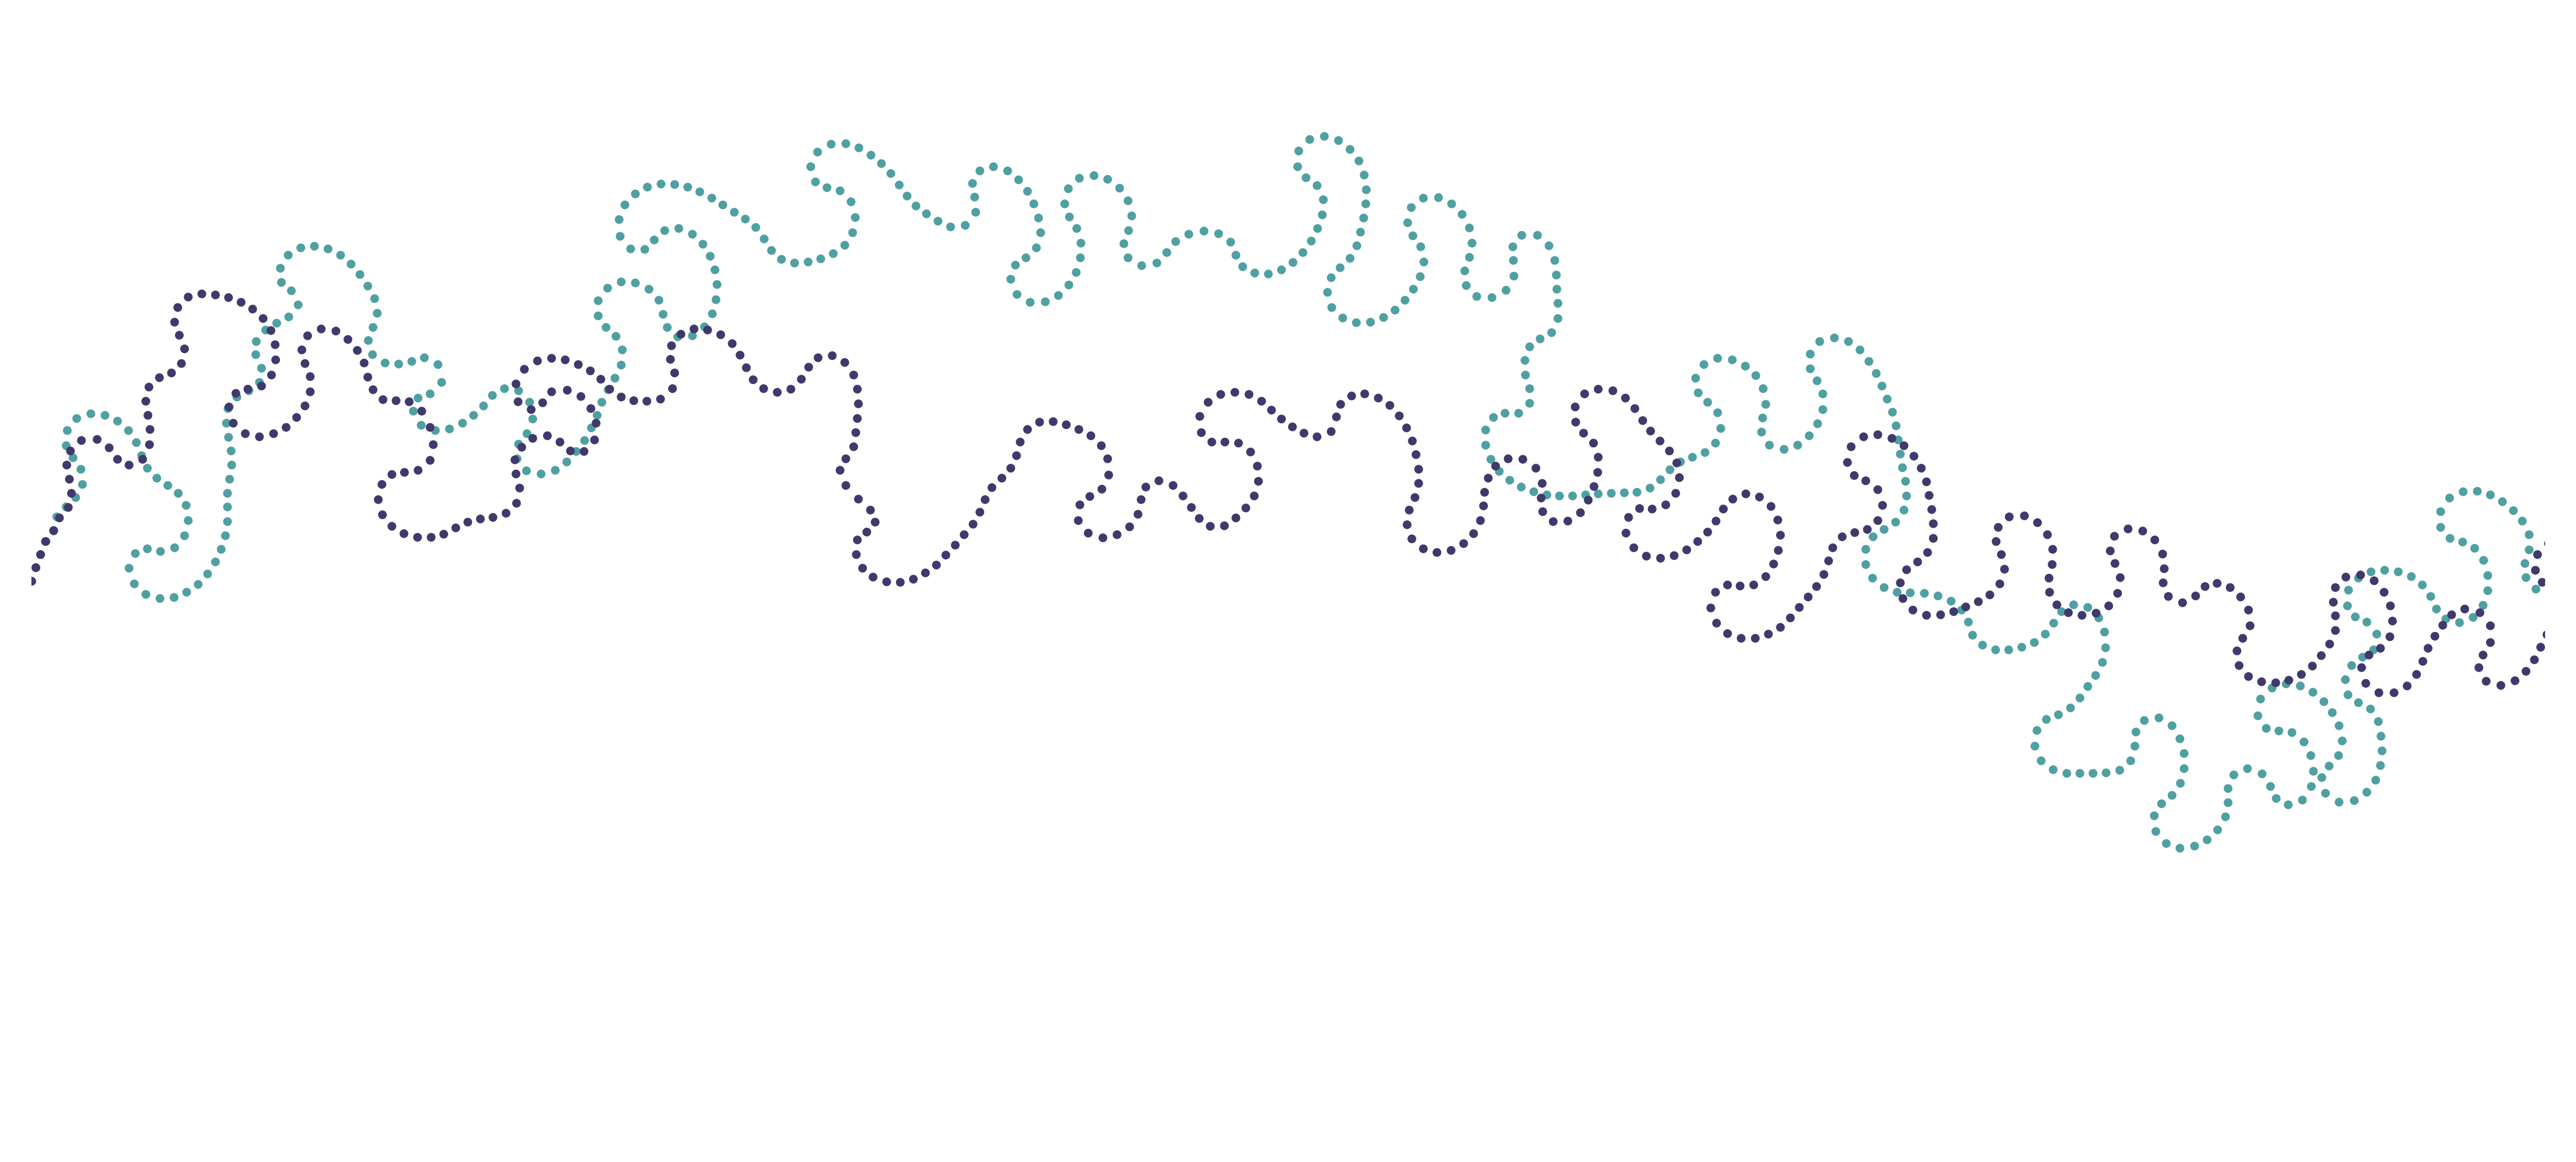

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean

x_min, x_max = 0, 10000
y_min, y_max = -2000, 2000
timestep = 300

# Colors
deep = cmocean.cm.deep
color_ref  = np.array(deep(0.433333)[:3])   # reference: blue(ish)
color_pert = np.array(deep(0.833333)[:3])   # perturbed: lighter color

# --- Get node coordinates ---
x_ref = chb_ref.channels[timestep].x
y_ref = chb_ref.channels[timestep].y
pert_ch = perturbed_runs[0].channels[timestep]
x_pert = pert_ch.x
y_pert = pert_ch.y

fig, ax = plt.subplots(figsize=(8, 3.5))
# Reference nodes
ax.scatter(x_ref, y_ref, c=[color_ref], s=1, label='Reference', zorder=2)
# Perturbed nodes
ax.scatter(x_pert, y_pert, c=[color_pert], s=1, label='Perturbed', zorder=2)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_xticks([x_min, x_max])
ax.set_yticks([y_min, y_max])
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.margins(0)
plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time as timer

# -------------------------------------
# USER CONFIG
# -------------------------------------
grid_cols_sizes = [200]

extent = (0, 10_000, -2500, 2500)
n_seg_rasterize = 10

timesteps = len(chb_ref.channels)
actual_n_runs = len(perturbed_runs)
grid_logs = {}  # <- Stores results outside the loop

# -------------------------------------
# Helpers
# -------------------------------------
def rasterize_channel(x, y, rows, cols, extent, n_seg=10):
    x_min, x_max, y_min, y_max = extent
    dx = (x_max - x_min) / cols
    dy = (y_max - y_min) / rows
    canvas = np.zeros((rows, cols), dtype=np.int8)
    for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:]):
        xs = np.linspace(x0, x1, n_seg)
        ys = np.linspace(y0, y1, n_seg)
        c = ((xs - x_min) / dx).astype(int)
        r = ((ys - y_min) / dy).astype(int)
        m = (0 <= c) & (c < cols) & (0 <= r) & (r < rows)
        canvas[r[m], c[m]] = 1
    return canvas

def plot_log_norms(grid_logs, saved_ts):
    plt.figure(figsize=(12, 8))
    for label, log_norm in grid_logs.items():
        plt.plot(np.arange(len(log_norm)) * saved_ts, log_norm, marker='.', linestyle='-', markersize=3, label=label)
    plt.xlabel(f'Timestep (t * {saved_ts})')
    plt.ylabel('Log Separation Norm (ln ||δφ||₂)')
    plt.title('Log Separation Growth for Different Grid Resolutions (Rows = Cols/2)')
    plt.legend(title="Grid (Rows x Cols)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------
# Compute and append
# -------------------------------------
for N_cols in grid_cols_sizes:
    rows = N_cols // 2
    cols = N_cols
    print(f"\nProcessing Grid: {rows} rows x {cols} cols")

    all_norms = np.full((actual_n_runs, timesteps), np.nan)
    start_calc_time = timer.time()

    for i in range(actual_n_runs):
        if len(perturbed_runs[i].channels) != timesteps:
            print(f"  Warning: Length mismatch for run {i}. Skipping.")
            continue
        for t in range(timesteps):
            ch0 = chb_ref.channels[t]
            ch1 = perturbed_runs[i].channels[t]
            if ch0 is None or ch1 is None:
                continue
            x0, y0 = getattr(ch0, 'x', None), getattr(ch0, 'y', None)
            x1, y1 = getattr(ch1, 'x', None), getattr(ch1, 'y', None)
            if any(v is None for v in (x0, y0, x1, y1)) or len(x0) < 2 or len(x1) < 2:
                continue
    
            try:
                g0 = rasterize_channel(x0, y0, rows, cols, extent, n_seg_rasterize)
                g1 = rasterize_channel(x1, y1, rows, cols, extent, n_seg_rasterize)
            except Exception:
                continue
            grid_diff = g1 - g0
            norm = np.linalg.norm(grid_diff)
            assert norm >= 0, f"Negative norm at run {i}, time {t}"
            norm = max(norm, 0.0)
            all_norms[i, t] = norm

    # --- Average and log transform ---
    avg_norm = np.nanmean(all_norms, axis=0) if actual_n_runs > 0 else np.full(timesteps, np.nan)
    valid_indices = ~np.isnan(avg_norm)
    log_norm = np.full_like(avg_norm, np.nan)
    if np.any(valid_indices):
        valid_norms = avg_norm[valid_indices]
        valid_norms[valid_norms < 1e-15] = 1e-15
        log_norm[valid_indices] = np.log(valid_norms)

    label = f"{rows}x{cols}"
    grid_logs[label] = log_norm

    elapsed = timer.time() - start_calc_time
    print(f"  Done in {elapsed:.2f} sec.")

print("Script finished.")


Processing Grid: 100 rows x 200 cols
  Done in 12.10 sec.
Script finished.


In [162]:
import numpy as np
import matplotlib.pyplot as plt
import time as timer

def rasterize_channel(x, y, rows, cols, extent, n_seg=1000):
    x_min, x_max, y_min, y_max = extent
    dx = (x_max - x_min) / cols
    dy = (y_max - y_min) / rows
    canvas = np.zeros((rows, cols), dtype=np.int8)
    for x0, y0, x1, y1 in zip(x[:-1], y[:-1], x[1:], y[1:]):
        xs = np.linspace(x0, x1, n_seg)
        ys = np.linspace(y0, y1, n_seg)
        c = ((xs - x_min) / dx).astype(int)
        r = ((ys - y_min) / dy).astype(int)
        m = (0 <= c) & (c < cols) & (0 <= r) & (r < rows)
        canvas[r[m], c[m]] = 1
    return canvas

def compute_log_norms_for_grids(chb_ref, perturbed_runs, grid_cols_sizes, extent, n_seg_rasterize=10):
    timesteps = len(chb_ref.channels)
    actual_n_runs = len(perturbed_runs)
    grid_logs = {}

    for N_cols in grid_cols_sizes:
        rows = N_cols // 2
        cols = N_cols
        print(f"\nProcessing Grid: {rows} rows x {cols} cols")

        all_norms = np.full((actual_n_runs, timesteps), np.nan)
        start_calc_time = timer.time()

        for i in range(actual_n_runs):
            if len(perturbed_runs[i].channels) != timesteps:
                print(f"  Warning: Length mismatch for run {i}. Skipping.")
                continue
            for t in range(timesteps):
                ch0 = chb_ref.channels[t]
                ch1 = perturbed_runs[i].channels[t]
                if ch0 is None or ch1 is None:
                    continue
                x0, y0 = getattr(ch0, 'x', None), getattr(ch0, 'y', None)
                x1, y1 = getattr(ch1, 'x', None), getattr(ch1, 'y', None)
                if any(v is None for v in (x0, y0, x1, y1)) or len(x0) < 2 or len(x1) < 2:
                    continue

                try:
                    g0 = rasterize_channel(x0, y0, rows, cols, extent, n_seg_rasterize)
                    g1 = rasterize_channel(x1, y1, rows, cols, extent, n_seg_rasterize)
                except Exception:
                    continue

                grid_diff = g1 - g0
                norm = np.linalg.norm(grid_diff)
                all_norms[i, t] = max(norm, 0.0)

        avg_norm = np.nanmean(all_norms, axis=0) if actual_n_runs > 0 else np.full(timesteps, np.nan)
        valid_indices = ~np.isnan(avg_norm)
        log_norm = np.full_like(avg_norm, np.nan)
        if np.any(valid_indices):
            valid_norms = avg_norm[valid_indices]
            valid_norms[valid_norms < 1e-15] = 1e-15
            log_norm[valid_indices] = np.log(valid_norms)

        label = f"{rows}x{cols}"
        grid_logs[label] = log_norm

        elapsed = timer.time() - start_calc_time
        print(f"  Done in {elapsed:.2f} sec.")

    return grid_logs

grid_cols_sizes = [10,20,50,100,200,500,1000,2000,5000,10000]


extent = (0, 10_000, -2500, 2500)

grid_logs = compute_log_norms_for_grids(
    chb_ref=chb_ref,
    perturbed_runs=perturbed_runs,
    grid_cols_sizes=grid_cols_sizes,
    extent=extent,
    n_seg_rasterize=100
)


Processing Grid: 5 rows x 10 cols
  Done in 12.89 sec.

Processing Grid: 10 rows x 20 cols
  Done in 12.59 sec.

Processing Grid: 25 rows x 50 cols
  Done in 12.36 sec.

Processing Grid: 50 rows x 100 cols
  Done in 12.41 sec.

Processing Grid: 100 rows x 200 cols
  Done in 12.48 sec.

Processing Grid: 250 rows x 500 cols
  Done in 12.48 sec.

Processing Grid: 500 rows x 1000 cols
  Done in 12.85 sec.

Processing Grid: 1000 rows x 2000 cols
  Done in 14.27 sec.

Processing Grid: 2500 rows x 5000 cols
  Done in 24.34 sec.

Processing Grid: 5000 rows x 10000 cols
  Done in 69.19 sec.


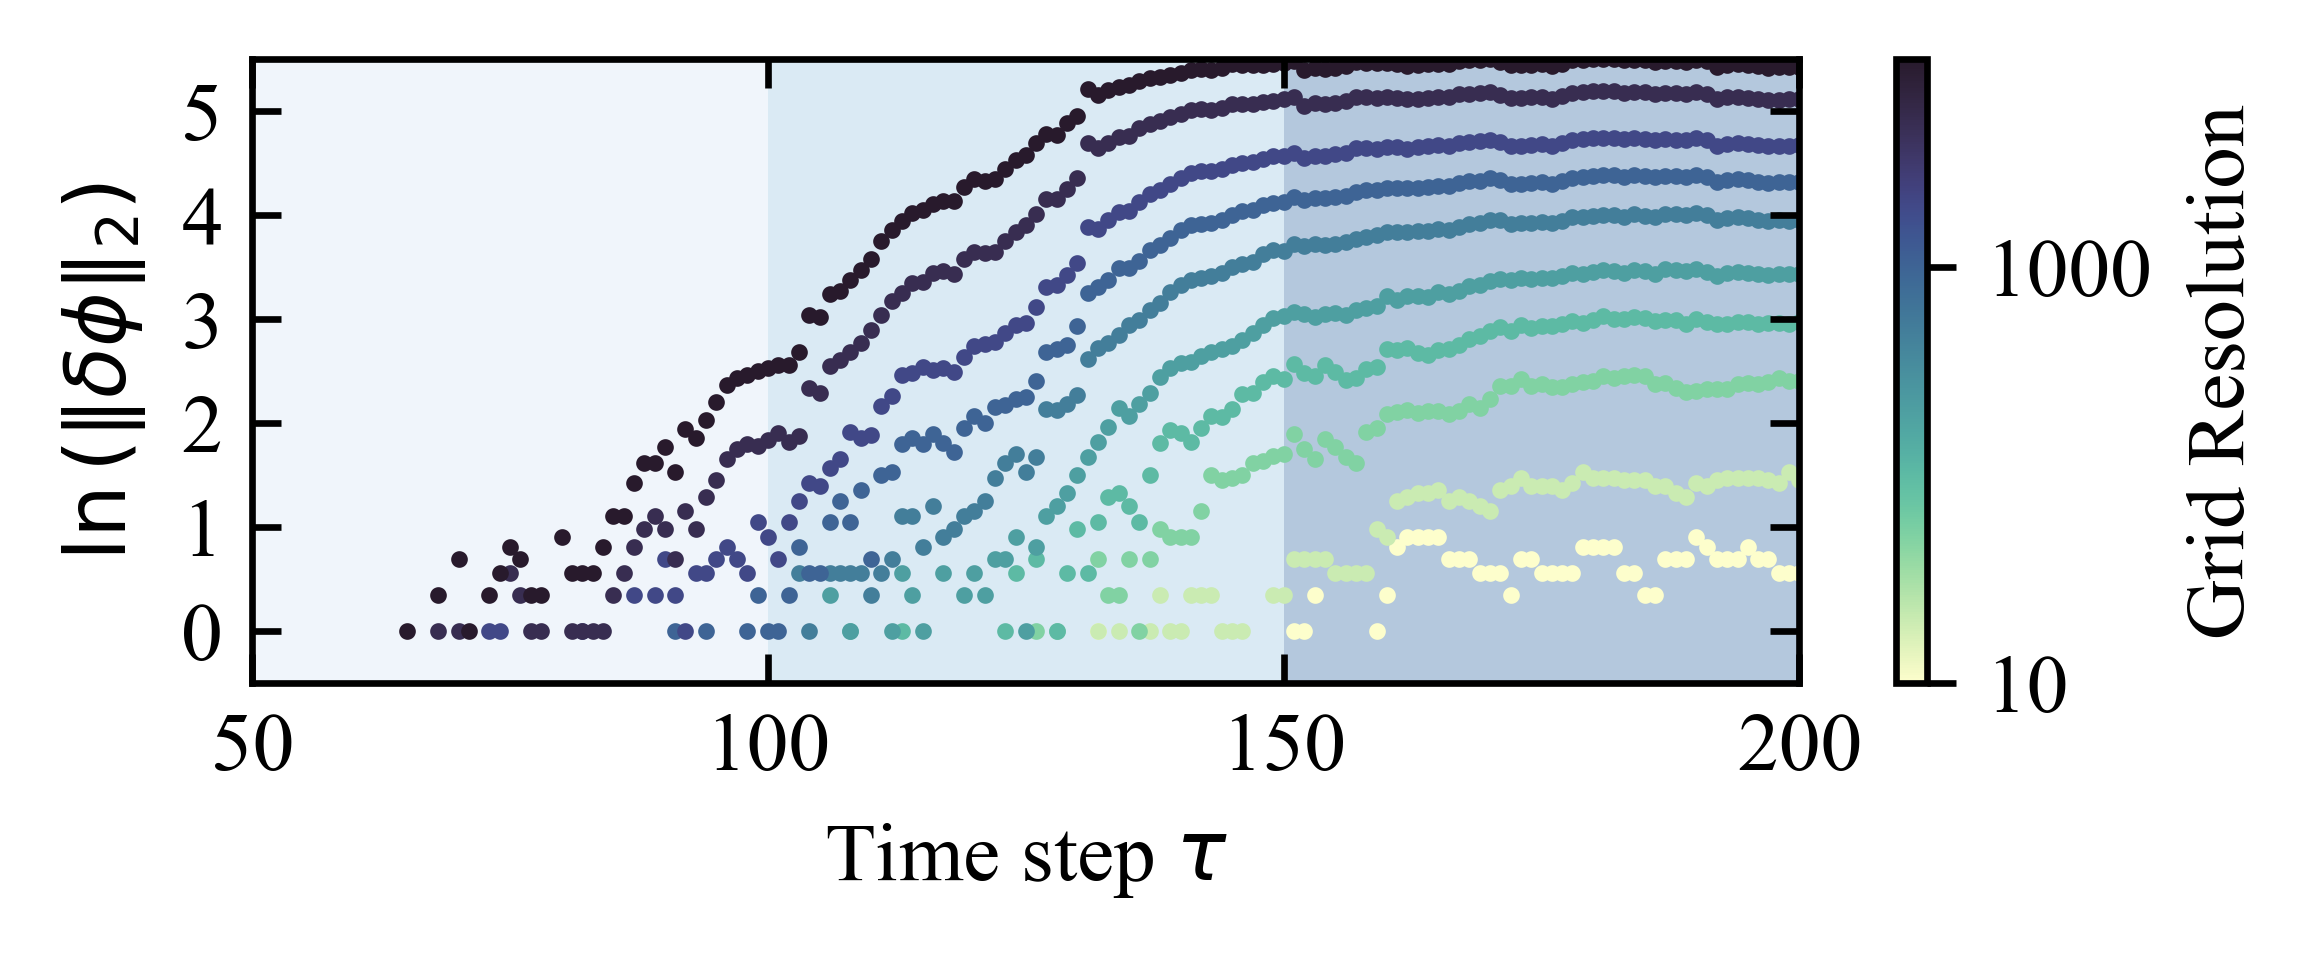

In [163]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import LogLocator, ScalarFormatter

def plot_log_norms(grid_logs, saved_ts):
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(4, 1.7))

    # --- Extract numeric grid sizes from labels like "50x100" ---
    col_sizes = [int(label.split('x')[1]) for label in grid_logs.keys()]
    col_sizes_sorted = sorted(col_sizes)

    # --- Use cmocean deep colormap and log norm for colorbar ---
    cmap = cmocean.cm.deep
    norm = LogNorm(vmin=min(col_sizes_sorted), vmax=max(col_sizes_sorted))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # --- Shading 3 regions (using Blues from matplotlib for subtlety) ---
    from matplotlib.cm import Blues
    ax.axvspan(0, 100,  facecolor=Blues(0.2), alpha=0.3, zorder=0)
    ax.axvspan(100, 150, facecolor=Blues(0.6), alpha=0.2, zorder=0)
    ax.axvspan(150, 200, facecolor=Blues(0.9), alpha=0.3, zorder=0)

    # --- Plot each log norm with color by resolution ---
    for label in grid_logs:
        cols = int(label.split('x')[1])
        color = cmap(norm(cols))
        x = np.arange(len(grid_logs[label])) * saved_ts
        y = grid_logs[label]
        ax.scatter(x, y, color=color, s=1)

    # --- Formatting ---
    ax.set_xlabel(r'Time step $\tau$')
    ax.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
    ax.set_xlim([50, 200])
    ax.set_ylim([-0.5, 5.5])
    ax.set_xticks([50, 100, 150, 200])
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(axis='both', direction='in', top=True, right=True)

    # --- Colorbar: log axis, only 10, 100, 1000 ---
    cbar_ticks = [10, 100, 1000]
    cbar = fig.colorbar(sm, ax=ax, pad=0.05)
    cbar.set_label("Grid Resolution")
    cbar.set_ticks(cbar_ticks)
    cbar.ax.set_yticklabels([str(tick) for tick in cbar_ticks])
    cbar.ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))

    plt.tight_layout()
    plt.show()

# Example call (make sure grid_logs is defined):
plot_log_norms(grid_logs, saved_ts=1)


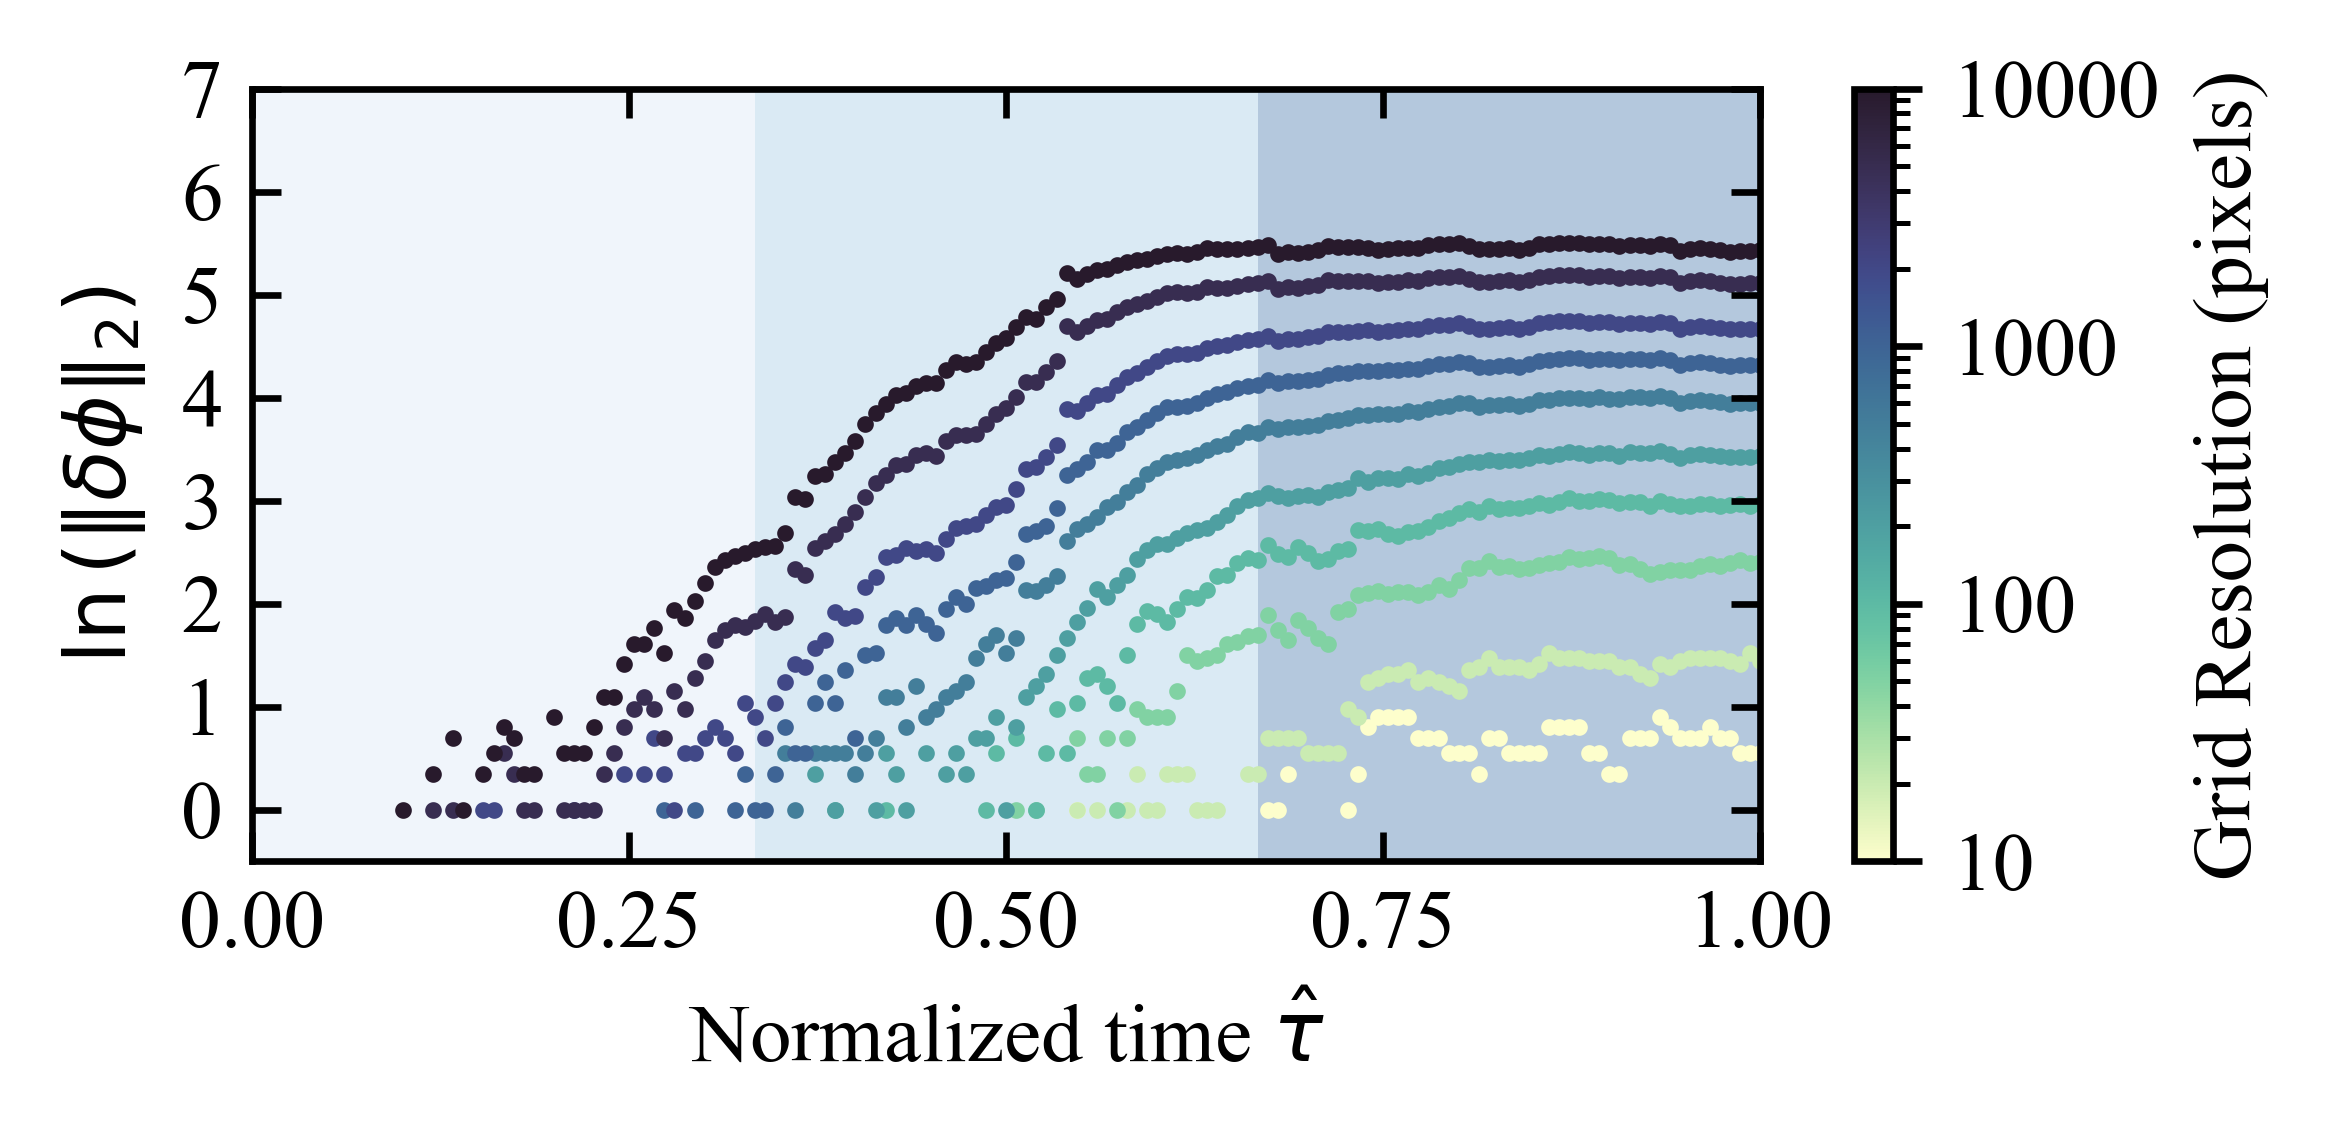

In [178]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.cm import Blues

def plot_log_norms(grid_logs, saved_ts):
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(4, 2))

    # Get all grid column sizes present in the logs
    col_sizes = [int(label.split('x')[1]) for label in grid_logs.keys()]
    col_sizes_sorted = sorted(col_sizes)

    cmap = cmocean.cm.deep
    norm = LogNorm(vmin=min(col_sizes_sorted), vmax=max(col_sizes_sorted))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Shading for normalized coordinates (same as before)
    ax.axvspan(0, (100 - 50) / 150, facecolor=Blues(0.2), alpha=0.3, zorder=0)
    ax.axvspan((100 - 50) / 150, (150 - 50) / 150, facecolor=Blues(0.6), alpha=0.2, zorder=0)
    ax.axvspan((150 - 50) / 150, (200 - 50) / 150, facecolor=Blues(0.9), alpha=0.3, zorder=0)

    for label in grid_logs:
        cols = int(label.split('x')[1])
        color = cmap(norm(cols))
        x = np.arange(len(grid_logs[label])) * saved_ts
        y = np.array(grid_logs[label])
        mask = (x >= 50) & (x <= 200) & (y >= 0)
        x_norm = (x[mask] - 50) / 150
        y = y[mask]
        ax.scatter(x_norm, y, color=color, s=1)

    ax.set_xlabel(r'Normalized time $\hat{\tau}$')
    ax.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.5, 7])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 1, 2, 3, 4, 5,6, 7])
    ax.tick_params(axis='both', direction='in', top=True, right=True)

    # Log colorbar, showing only 10, 100, 1000, 10000 (if within the data range)
    all_ticks = [10, 100, 1000, 10000]
    cbar_ticks = [tick for tick in all_ticks if min(col_sizes_sorted) <= tick <= max(col_sizes_sorted)]
    cbar = fig.colorbar(sm, ax=ax, pad=0.05)
    cbar.set_label("Grid Resolution (pixels)")
    cbar.set_ticks(cbar_ticks)
    cbar.ax.set_yticklabels([str(tick) for tick in cbar_ticks])

    plt.tight_layout()
    plt.show()

# Example call
plot_log_norms(grid_logs, saved_ts=1)


Grid 5x10: slope = 1.0833
Grid 10x20: slope = 5.0037
Grid 25x50: slope = 6.6724
Grid 50x100: slope = 7.9960
Grid 100x200: slope = 10.5785
Grid 250x500: slope = 12.1094
Grid 500x1000: slope = 12.8551
Grid 1000x2000: slope = 11.3588
Grid 2500x5000: slope = 12.4832
Grid 5000x10000: slope = 13.0682


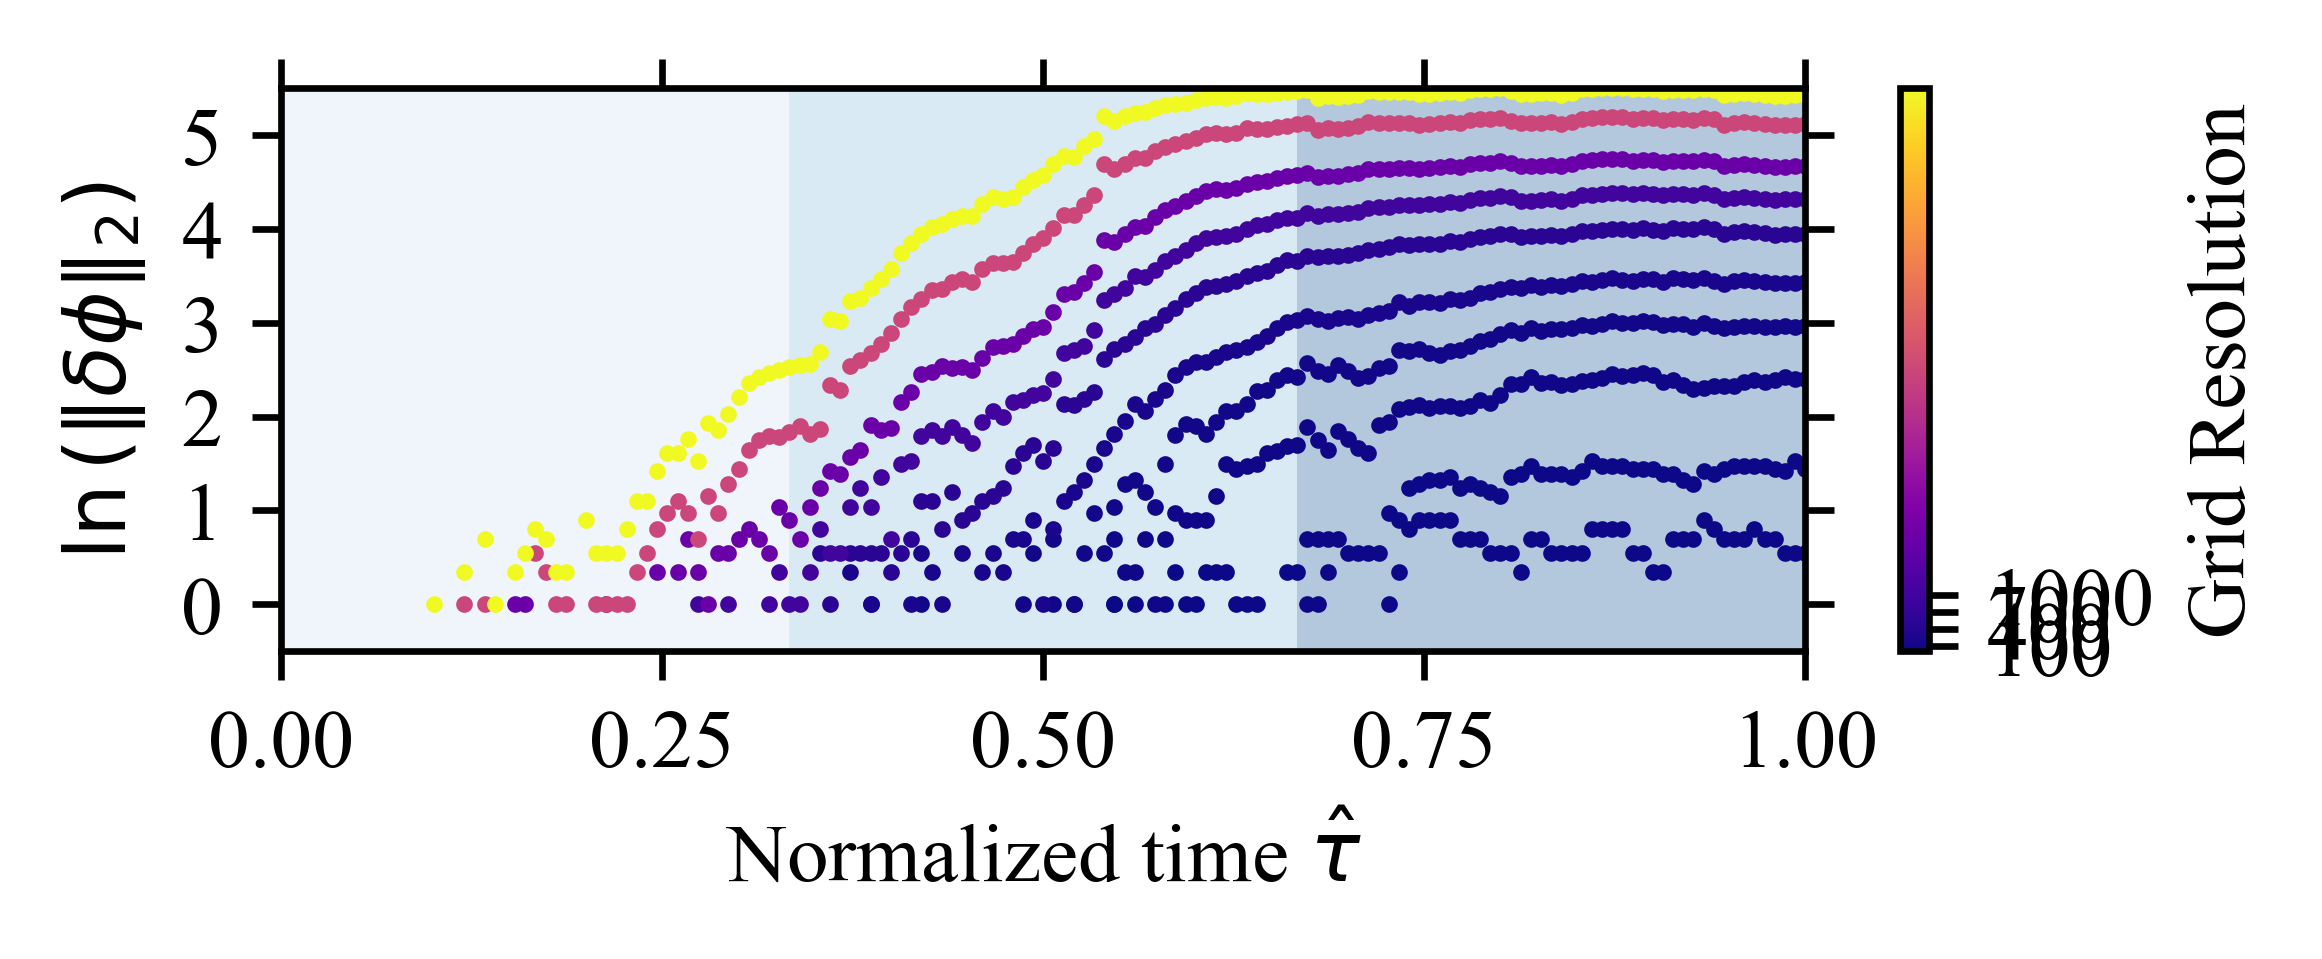

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import plasma, Blues
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_log_norms_and_slopes(grid_logs, saved_ts):
    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(4, 1.7))

    col_sizes = [int(label.split('x')[1]) for label in grid_logs.keys()]
    col_sizes_sorted = sorted(col_sizes)

    cmap = plasma
    norm = Normalize(vmin=min(col_sizes_sorted), vmax=max(col_sizes_sorted))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax.axvspan(0, (100 - 50) / 150, facecolor=Blues(0.2), alpha=0.3, zorder=0)
    ax.axvspan((100 - 50) / 150, (150 - 50) / 150, facecolor=Blues(0.6), alpha=0.2, zorder=0)
    ax.axvspan((150 - 50) / 150, (200 - 50) / 150, facecolor=Blues(0.9), alpha=0.3, zorder=0)

    for label in sorted(grid_logs.keys(), key=lambda k: int(k.split('x')[1])):
        cols = int(label.split('x')[1])
        color = cmap(norm(cols))
        x = np.arange(len(grid_logs[label])) * saved_ts
        y = np.array(grid_logs[label])

        # Mask: restrict to 50 ≤ x ≤ 200 and y ≥ 0
        mask = (x >= 50) & (x <= 200) & (y >= 0)
        x_masked = x[mask]
        y_masked = y[mask]

        # Normalize x to [0, 1]
        x_norm = (x_masked - 50) / 150

        # Plot
        ax.scatter(x_norm, y_masked, color=color, s=1)

        # Fit to first 50 points if enough
        if len(x_norm) >= 30:
            x_fit = x_norm[:50]
            y_fit = y_masked[:50]
            A = np.vstack([x_fit, np.ones_like(x_fit)]).T
            m, b = np.linalg.lstsq(A, y_fit, rcond=None)[0]
            print(f"Grid {label}: slope = {m:.4f}")
        else:
            print(f"Grid {label}: not enough data to fit (only {len(x_norm)} points)")

    ax.set_xlabel(r'Normalized time $\hat{\tau}$')
    ax.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.5, 5.5])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.tick_params(axis='both', direction='out', top=True, right=True)

    cbar = fig.colorbar(sm, ax=ax, pad=0.05, ticks=[100, 400, 700, 1000])
    cbar.set_label("Grid Resolution")

    plt.tight_layout()
    plt.show()

plot_log_norms_and_slopes(grid_logs, saved_ts=1)


/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_27499/3024434489.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 15000)


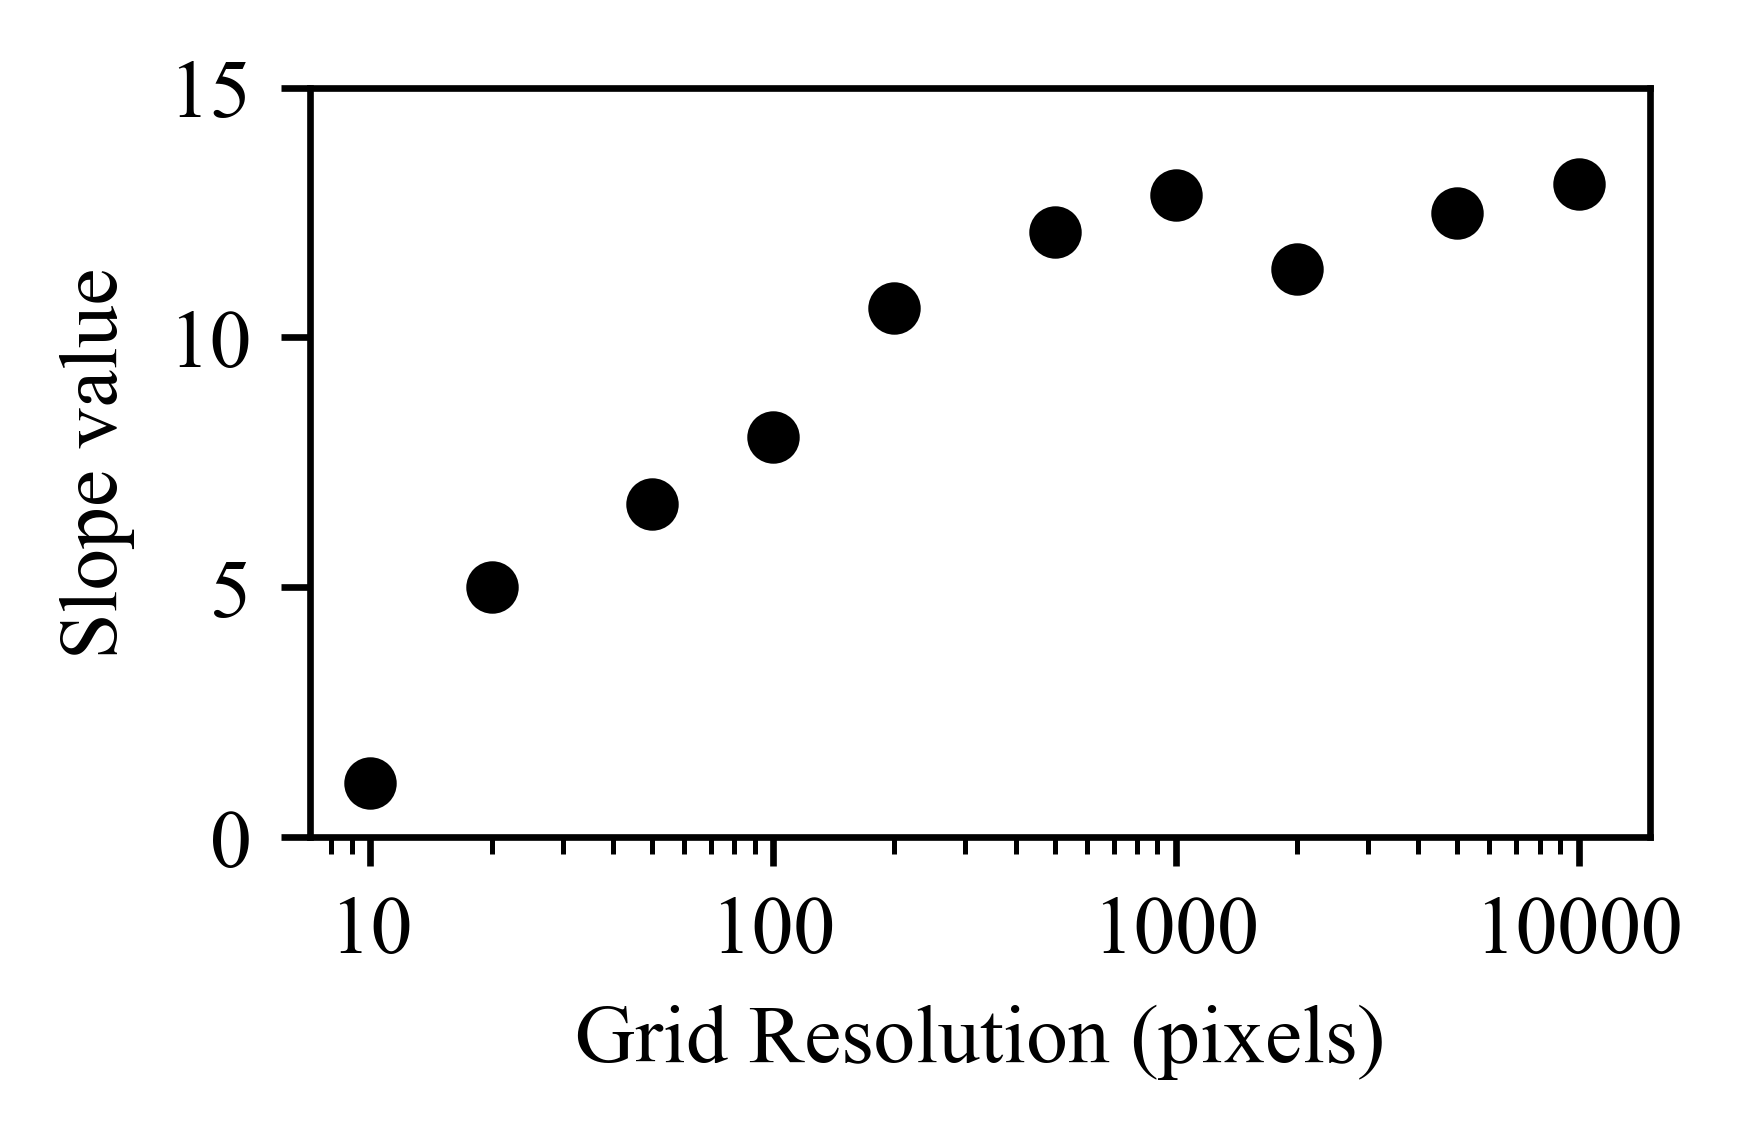

In [177]:
import matplotlib.pyplot as plt
import numpy as np

# Provided data
col_sizes = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
slopes = [1.0833, 5.0037, 6.6724, 7.9960, 10.5785, 12.1094, 12.8551, 11.3588, 12.4832, 13.0682]

plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(3,2))

ax.scatter(col_sizes, slopes, color='k', s=28, zorder=2)

ax.set_xscale('log')
ax.set_xlabel("Grid Resolution (pixels)")
ax.set_ylabel("Slope value")
ax.set_xticks([10, 100, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(0, 15000)
ax.set_ylim(0,15)

plt.tight_layout()
plt.show()


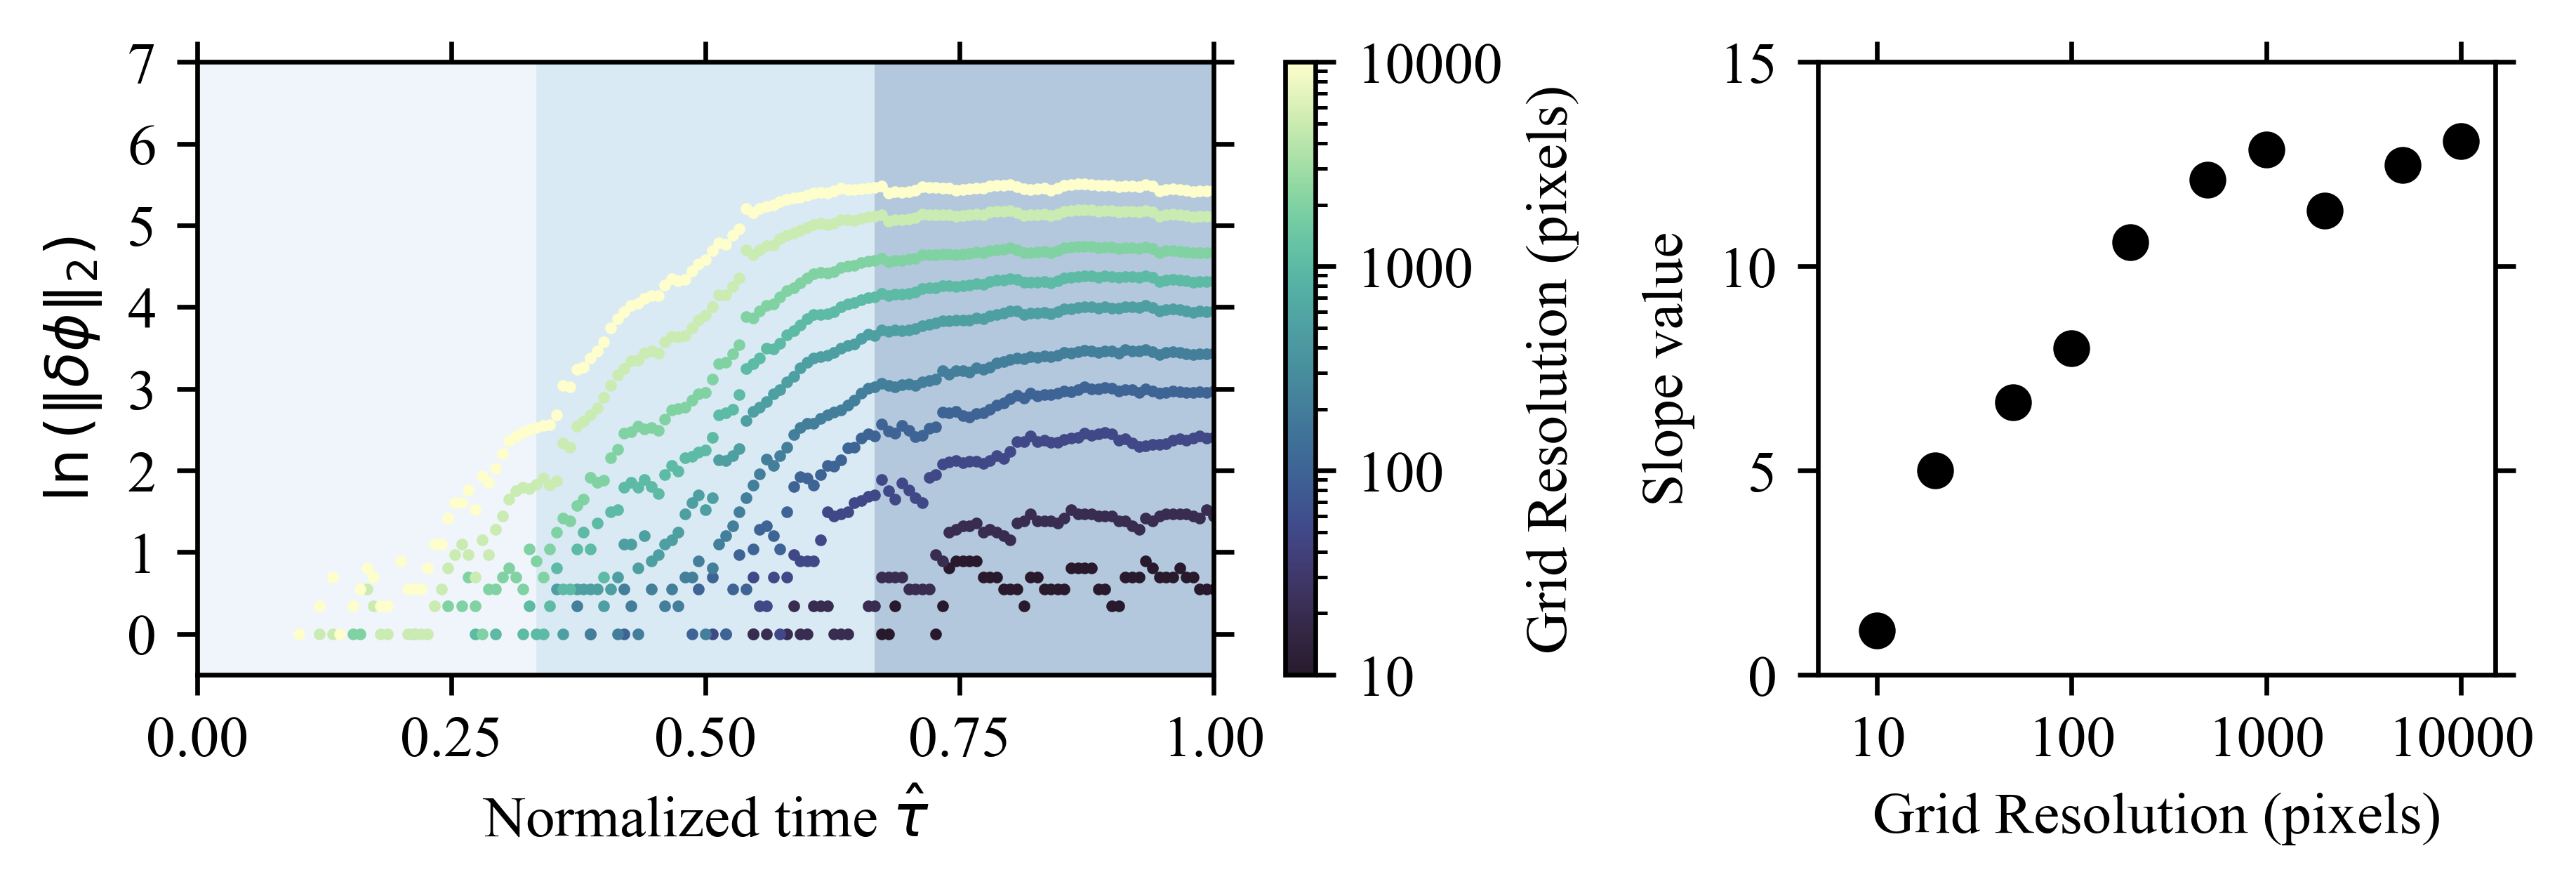

In [187]:
import matplotlib.pyplot as plt
import numpy as np
import cmocean
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib.cm import Blues




def plot_comparison(grid_logs, saved_ts, col_sizes, slopes):
    plt.rcParams["font.family"] = "Times New Roman"
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(6, 2),
        gridspec_kw={'width_ratios': [1.5, 1], 'wspace': 0.05},
        constrained_layout=True
    )
    # --- LEFT PANEL: Norm vs. Time (same as your original, with colorbar) ---
    col_sizes_grid = [int(label.split('x')[1]) for label in grid_logs.keys()]
    col_sizes_sorted = sorted(col_sizes_grid)
    cmap = cmocean.cm.deep_r
    norm = LogNorm(vmin=min(col_sizes_sorted), vmax=max(col_sizes_sorted))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    ax1.axvspan(0, (100 - 50) / 150, facecolor=Blues(0.2), alpha=0.3, zorder=0)
    ax1.axvspan((100 - 50) / 150, (150 - 50) / 150, facecolor=Blues(0.6), alpha=0.2, zorder=0)
    ax1.axvspan((150 - 50) / 150, (200 - 50) / 150, facecolor=Blues(0.9), alpha=0.3, zorder=0)
    for label in grid_logs:
        cols = int(label.split('x')[1])
        color = cmap(norm(cols))
        x = np.arange(len(grid_logs[label])) * saved_ts
        y = np.array(grid_logs[label])
        mask = (x >= 50) & (x <= 200) & (y >= 0)
        x_norm = (x[mask] - 50) / 150
        y = y[mask]
        ax1.scatter(x_norm, y, color=color, s=1)
    ax1.set_xlabel(r'Normalized time $\hat{\tau}$')
    ax1.set_ylabel(r'$\ln\left(\|\delta\phi\|_2\right)$')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([-0.5, 7])
    ax1.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7])
    ax1.tick_params(axis='both', direction='out', top=True, right=True)

    all_ticks = [10, 100, 1000, 10000]
    cbar_ticks = [tick for tick in all_ticks if min(col_sizes_sorted) <= tick <= max(col_sizes_sorted)]
    cbar = fig.colorbar(sm, ax=ax1, pad=0.02)
    cbar.set_label("Grid Resolution (pixels)")
    cbar.set_ticks(cbar_ticks)
    cbar.ax.set_yticklabels([str(tick) for tick in cbar_ticks])

    # --- RIGHT PANEL: Slope vs. Grid Resolution ---
    ax2.scatter(col_sizes, slopes, color='k', s=28, zorder=2)
    ax2.set_xscale('log')
    ax2.set_xlabel("Grid Resolution (pixels)")
    ax2.set_ylabel("Slope value")
    ax2.set_xticks([10, 100, 1000, 10000])
    ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax2.set_xlim(5, 15000)
    ax2.set_ylim(0, 15)
    ax2.tick_params(axis='both', direction='out', top=True, right=True)

    plt.show()

# Example call (make sure grid_logs, col_sizes, and slopes are defined):
plot_comparison(grid_logs, saved_ts=1, col_sizes=col_sizes, slopes=slopes)
